In [2]:
#Importing
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

# Data preprocessing

In [22]:
# ... existing code ...

def get_data(normalize, train_data, test_data):
    train_data, test_data = train_data.align(test_data, join='outer', axis=1)

    # Convert booleans to int64
    boolean_columns = train_data.select_dtypes(include=[bool])
    train_data[boolean_columns.columns] = boolean_columns.astype('int64')
    test_data[boolean_columns.columns] = test_data[boolean_columns.columns].astype('int64')

    # Drop unnecessary columns
    train_data = train_data.drop(['BsmtFinSF1', 'BsmtFinSF2', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtUnfSF', 'GarageArea', 'GarageCars', 'TotalBsmtSF'], axis=1)
    test_data = test_data.drop(['BsmtFinType1', 'BsmtFinType2', 'FireplaceQu', 'GarageCond', 'GarageFinish', 'GarageQual', 'GarageType'], axis=1)

    # OneHotEncoding
    train_data = pd.get_dummies(train_data)
    test_data = pd.get_dummies(test_data)

    # Align train and test data
    train_data, test_data = train_data.align(test_data, join='left', axis=1, fill_value=0)

    # Handle missing values by filling them with the median
    train_data = train_data.fillna(train_data.median(numeric_only=True))
    test_data = test_data.fillna(test_data.median(numeric_only=True))

    # Separate the target variable
    sale_price = train_data['SalePrice']
    train_data = train_data.drop('SalePrice', axis=1)

    # Select top 20 features based on correlation with SalePrice
    correlation = train_data.corrwith(sale_price).abs().sort_values(ascending=False)
    top_features = correlation.head(20).index

    # Print the top features
    print("Top 20 features based on correlation with SalePrice:")
    print(top_features)

    train_data = train_data[top_features]
    test_data = test_data[top_features]

    # Scaling
    if normalize:
        scaler = MinMaxScaler()
        train_data = scaler.fit_transform(train_data)
        test_data = scaler.transform(test_data)

    # Train test split
    X_train, X_test, y_train, y_test = train_test_split(train_data, sale_price, random_state=42)
    return X_train, X_test, y_train, y_test, test_data, top_features

# Model building
X_train, X_test, y_train, y_test, test_data, top_features = get_data(False, train_data, test_data)

# Now you can print top_features outside the function
print("Top 20 features used in the model:")
print(top_features)

# ... existing code ...

Top 20 features based on correlation with SalePrice:
Index(['OverallQual', 'GrLivArea', '1stFlrSF', 'ExterQual_TA', 'FullBath',
       'BsmtQual_Ex', 'TotRmsAbvGrd', 'YearBuilt', 'KitchenQual_TA',
       'YearRemodAdd', 'KitchenQual_Ex', 'Foundation_PConc', 'MasVnrArea',
       'Fireplaces', 'GarageYrBlt', 'ExterQual_Gd', 'BsmtQual_TA',
       'ExterQual_Ex', 'BsmtFinType1_GLQ', 'HeatingQC_Ex'],
      dtype='object')
Top 20 features used in the model:
Index(['OverallQual', 'GrLivArea', '1stFlrSF', 'ExterQual_TA', 'FullBath',
       'BsmtQual_Ex', 'TotRmsAbvGrd', 'YearBuilt', 'KitchenQual_TA',
       'YearRemodAdd', 'KitchenQual_Ex', 'Foundation_PConc', 'MasVnrArea',
       'Fireplaces', 'GarageYrBlt', 'ExterQual_Gd', 'BsmtQual_TA',
       'ExterQual_Ex', 'BsmtFinType1_GLQ', 'HeatingQC_Ex'],
      dtype='object')


In [23]:
#X_train, X_test, y_train, y_test, test_data = get_data(False)
format(train_data.shape)

'(1460, 80)'

In [25]:
if 'Id' in train_data.columns:
    train_data = train_data.drop('Id', axis=1)
train_data.head(3)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [32]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1438 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1438 non-null   int64  
 1   MSZoning       1438 non-null   object 
 2   LotFrontage    1181 non-null   float64
 3   LotArea        1438 non-null   int64  
 4   Street         1438 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1438 non-null   object 
 7   LandContour    1438 non-null   object 
 8   Utilities      1438 non-null   object 
 9   LotConfig      1438 non-null   object 
 10  LandSlope      1438 non-null   object 
 11  Neighborhood   1438 non-null   object 
 12  Condition1     1438 non-null   object 
 13  Condition2     1438 non-null   object 
 14  BldgType       1438 non-null   object 
 15  HouseStyle     1438 non-null   object 
 16  OverallQual    1438 non-null   int64  
 17  OverallCond    1438 non-null   int64  
 18  YearBuilt    

count      1438.000000
mean     175844.522253
std       67475.861228
min       34900.000000
25%      129500.000000
50%      161500.000000
75%      210000.000000
max      415298.000000
Name: SalePrice, dtype: float64


<Axes: xlabel='SalePrice', ylabel='Count'>

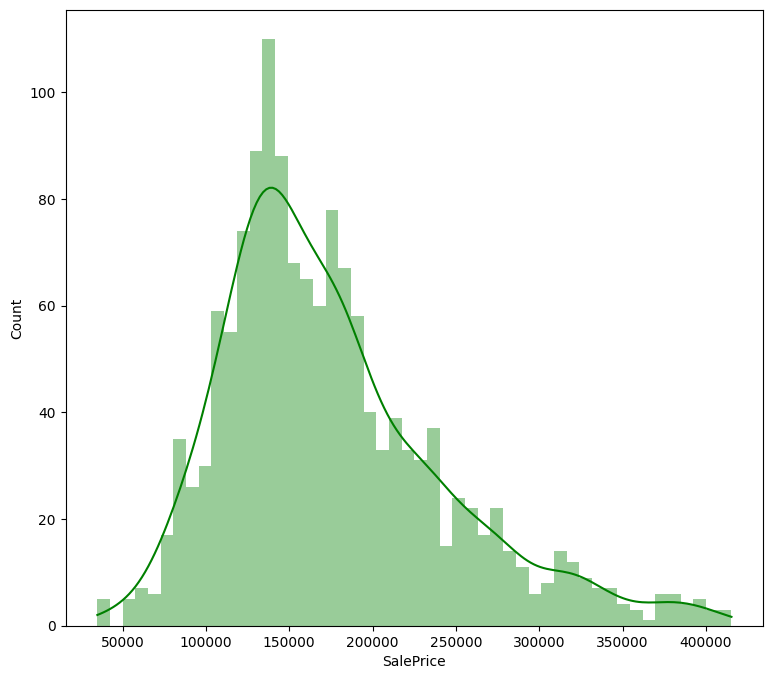

In [33]:
print(train_data['SalePrice'].describe())
plt.figure(figsize=(9, 8))
sns.histplot(train_data['SalePrice'], color='g', bins=50, kde=True, alpha=0.4, edgecolor=None)
#sns.distplot(train_data['SalePrice'], color='g', bins=50, hist_kws={'alpha': 0.4})

count      1409.000000
mean     171509.215046
std       60910.702716
min       34900.000000
25%      129000.000000
50%      160000.000000
75%      205000.000000
max      360000.000000
Name: SalePrice, dtype: float64


<Axes: xlabel='SalePrice', ylabel='Count'>

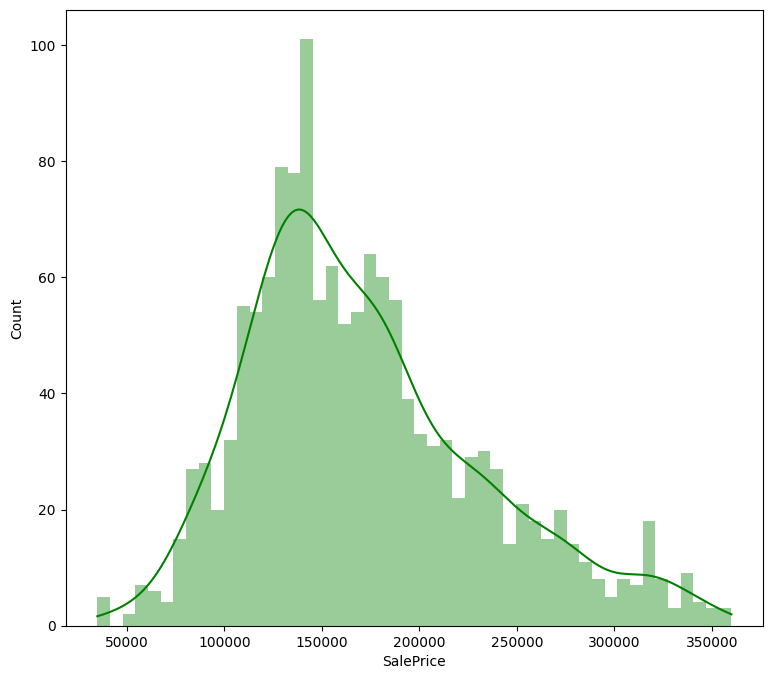

In [35]:
# Calculate mean and standard deviation
mean_sale_price = train_data['SalePrice'].mean()
std_sale_price = train_data['SalePrice'].std()

# Filter out outliers
train_data = train_data[(train_data['SalePrice'] >= mean_sale_price - 3 * std_sale_price) & 
                        (train_data['SalePrice'] <= mean_sale_price + 3 * std_sale_price)]

# Describe the filtered data
print(train_data['SalePrice'].describe())

# Plot the distribution of SalePrice after removing outliers
plt.figure(figsize=(9, 8))
sns.histplot(train_data['SalePrice'], color='g', bins=50, kde=True, alpha=0.4, edgecolor=None)

In [36]:
list(set(train_data.dtypes.tolist()))

[dtype('float64'), dtype('int64'), dtype('O')]

In [37]:
train_num = train_data.select_dtypes(include=['float64', 'int64'])
train_num.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,0,61,0,0,0,0,0,2,2008,208500
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,298,0,0,0,0,0,0,5,2007,181500
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,0,42,0,0,0,0,0,9,2008,223500
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,0,35,272,0,0,0,0,2,2006,140000
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,192,84,0,0,0,0,0,12,2008,250000


# Model building

In [39]:
# Adjust the unpacking to match the number of returned values
X_train, X_test, y_train, y_test, test_data, top_features = get_data(False, train_data, test_data)

# Now you can print top_features outside the function
print("Top 20 features used in the model:")
print(top_features)

Top 20 features based on correlation with SalePrice:
Index(['OverallQual', 'GrLivArea', 'ExterQual_TA', 'ExterQual_Gd', 'FullBath',
       'YearBuilt', 'KitchenQual_TA', 'YearRemodAdd', '1stFlrSF',
       'Foundation_PConc', 'TotRmsAbvGrd', 'BsmtQual_TA', 'GarageYrBlt',
       'KitchenQual_Gd', 'Fireplaces', 'HeatingQC_Ex', 'GarageFinish_Unf',
       'BsmtFinType1_GLQ', 'GarageType_Attchd', 'BsmtQual_Gd'],
      dtype='object')
Top 20 features used in the model:
Index(['OverallQual', 'GrLivArea', 'ExterQual_TA', 'ExterQual_Gd', 'FullBath',
       'YearBuilt', 'KitchenQual_TA', 'YearRemodAdd', '1stFlrSF',
       'Foundation_PConc', 'TotRmsAbvGrd', 'BsmtQual_TA', 'GarageYrBlt',
       'KitchenQual_Gd', 'Fireplaces', 'HeatingQC_Ex', 'GarageFinish_Unf',
       'BsmtFinType1_GLQ', 'GarageType_Attchd', 'BsmtQual_Gd'],
      dtype='object')


c:\Users\enorton\Downloads\Tools\Lib\site-packages\numpy\lib\_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\enorton\Downloads\Tools\Lib\site-packages\numpy\lib\_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [40]:
model = Sequential([
    Dense(64, activation="relu"),
    Dense(32, activation="relu"),
    Dense(16, activation="relu"),
    Dense(1)
])

model.compile(
    loss=MeanSquaredError(),
    optimizer=Adam(learning_rate=0.0006)
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)
history = model.fit(X_train, y_train, epochs=150, validation_data=(X_test, y_test), verbose=0, callbacks=early_stopping)

Restoring model weights from the end of the best epoch: 150.


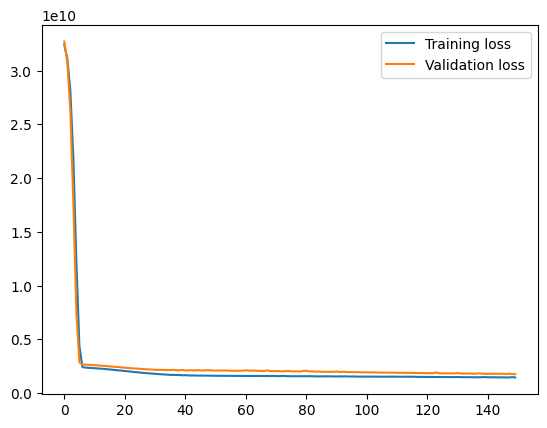

In [41]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()

In [42]:
mean_squared_error(model.predict(X_test), y_test)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


np.float64(1754997812.6446455)

In [44]:
# Load the sample submission file
sample_submission_df = pd.read_csv('sample_submission.csv')

# Ensure the test data is correctly preprocessed
# Make predictions on the test data
predictions = model.predict(test_data)

# Assign predictions to the 'SalePrice' column
sample_submission_df['SalePrice'] = predictions

# Save the submission file
sample_submission_df.to_csv('submission.csv', index=False)

# Display the first few rows of the submission file
sample_submission_df.head()

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


,Id,SalePrice
0,1461,111823.226562
1,1462,171986.015625
2,1463,171738.953125
3,1464,170460.296875
4,1465,168527.703125
